In [26]:
# Import all necessary libraries
import pandas as pd
print('Pandas version: ', pd.__version__)

import numpy as np
print('NumPy version: ', np.__version__)

import matplotlib
print('Matplotlib version: ', matplotlib.__version__)

from matplotlib import pyplot as plt

import sklearn
print('Scikit-Learn version: ', sklearn.__version__)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans

import pickle
print('Pickle version: ', pickle.format_version)

Pandas version:  1.5.0
NumPy version:  1.23.4
Matplotlib version:  3.6.1
Scikit-Learn version:  1.1.2
Pickle version:  4.0


In [2]:
# Define purchases : a client bought one or more 'libelles'
all_purchases = pd.read_csv('../KaDo.csv', usecols = ['CLI_ID', 'LIBELLE'])
all_purchases.to_csv('all_purchases.csv')

In [3]:
# Get a list of all unique clients
clients = np.unique(all_purchases['CLI_ID'])

In [4]:
# Get a list of all unique libelles
libelles = np.unique(all_purchases['LIBELLE'])

In [5]:
# Encode libelles so we can use them in our algorithms 
le = preprocessing.LabelEncoder()
le.fit(all_purchases['LIBELLE'])
print('Number of items is:', len(le.classes_))
libelles_encoded = le.transform(all_purchases['LIBELLE'])
all_purchases['LIBELLE_ENCODED'] = libelles_encoded

Number of items is: 1484


In [6]:
libelles_encoded_unique = np.unique(libelles_encoded)

In [114]:
# Save a list of strings
# Each string corresponds to the items bought by a client
def itemsListForClients(clients, clients_data):
    clients_items_list = []
    for client in clients:
        clients_items_list.append(str(list(clients_data[clients_data['CLI_ID'] == client]['LIBELLE_ENCODED'])).split('[')[1].split(']')[0])
    with open('items_list_for_client.txt', 'wb') as fp:
        pickle.dump(clients_items_list, fp)

In [115]:
itemsListForClients(clients, all_purchases)

In [7]:
# Load list of items for clients
clients_items_list = pickle.load(open('items_list_for_client.txt', 'rb'))
print('Items list for', len(clients), ' clients')
print('A list of first client bought items: \n', clients_items_list[:2]) 

Items list for 853514  clients
A list of first client bought items: 
 ['730, 730, 200, 361, 732', '415, 925, 733, 733, 733, 908, 908, 463, 463']


In [8]:
# Vectorize each string and return all vectors and feature names
def prepSparseMatrix(list_of_str):
    cv = CountVectorizer()
    sparseMatrix = cv.fit_transform(list_of_str)
    return sparseMatrix, cv.get_feature_names_out()

In [9]:
sparseMatrix, feature_names = prepSparseMatrix(clients_items_list)

In [42]:
# For each item, 0 if client did not buy it, 1 if client bought it
df_sparseMatrix = pd.DataFrame.sparse.from_spmatrix(sparseMatrix, index = clients, columns = feature_names)
df_sparseMatrix

,10,100,1000,1001,1002,1003,1004,1005,1006,1007,...,990,991,992,993,994,995,996,997,998,999
1490281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13290776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20163348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20200041,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20561854,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997048745,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997048751,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997048769,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997048777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Use elbow method to define the optimized K
# WCSS = Within Clusters Sum of Squares
class elbowMethod():
    def __init__(self, sparseMatrix):
        self.sparseMatrix = sparseMatrix
        self.wcss = list()
        self.differences = list()
    def run(self, init, upto, max_iterations = 300):
        for i in range(init, upto + 1):
            kmeans = KMeans(n_clusters=i, init = 'k-means++', max_iter = max_iterations, n_init = 10, random_state = 0)
            kmeans.fit(sparseMatrix)
            self.wcss.append(kmeans.inertia_)
        self.differences = list()
        for i in range(len(self.wcss)-1):
            self.differences.append(self.wcss[i] - self.wcss[i+1])
    def showPlot(self, boundary = 500, upto_cluster = None):
        if upto_cluster is None:
            WCSS = self.wcss
            DIFF = self.differences
        else:
            WCSS = self.wcss[:upto_cluster]
            DIFF = self.differences[:upto_cluster - 1]
        plt.figure(figsize=(15, 6))
        plt.subplot(121).set_title('Elbow Method Graph')
        plt.plot(range(1, len(WCSS) + 1), WCSS)
        plt.grid(b = True)
        plt.subplot(122).set_title('Differences in Each Two Consective Clusters')
        len_differences = len(DIFF)
        X_differences = range(1, len_differences + 1)
        plt.plot(X_differences, DIFF)
        plt.plot(X_differences, np.ones(len_differences)*boundary, 'r')
        plt.plot(X_differences, np.ones(len_differences)*(-boundary), 'r')
        plt.grid()
        plt.show()

/tmp/ipykernel_15629/3841504368.py:26: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b = True)


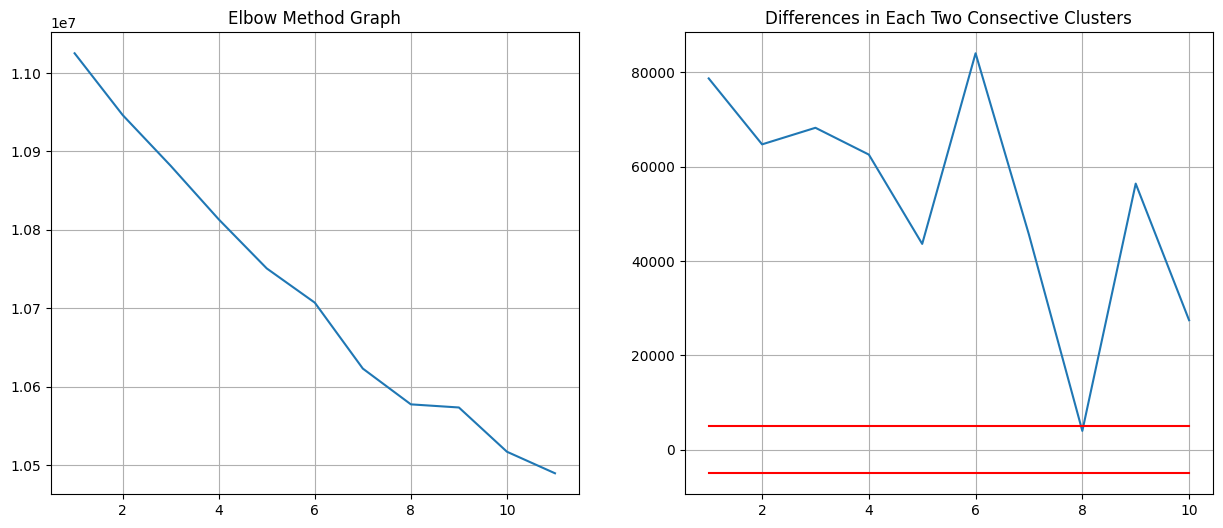

In [155]:
# Instantiate elbowMethod with our SM
elbow_method = elbowMethod(sparseMatrix) 
# Test SM with several K
elbow_method.run(6, 16)
elbow_method.showPlot(boundary = 5000)

In [30]:
model = Pipeline([
    ('norm', preprocessing.Normalizer()), 
    ('svd', TruncatedSVD()), 
    ('kmeans', KMeans(n_clusters=8, init="k-means++", max_iter=300, n_init=10, random_state=0))
])
model.fit(sparseMatrix)
pickle.dump(model, open("model.pkl", "wb"))

In [44]:
sparseMatrix[0]

<1x1474 sparse matrix of type '<class 'numpy.int64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [39]:
norm = preprocessing.Normalizer()
normalized = norm.fit_transform(sparseMatrix)
svd = TruncatedSVD()
df_svd = svd.fit_transform(normalized)

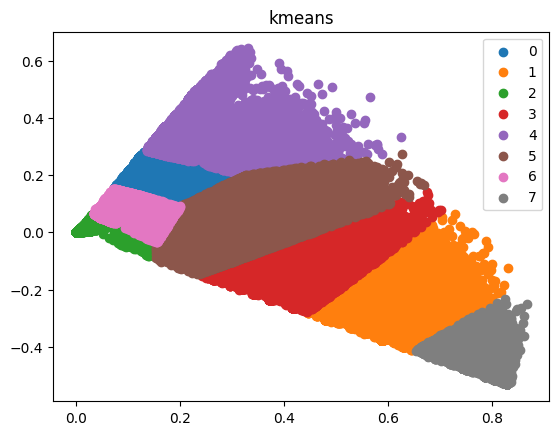

In [40]:
clusters = model['kmeans'].labels_
for u in np.unique(clusters):
    filtered_label = df_svd[clusters == u]
    plt.scatter(df_svd[clusters == u , 0] , df_svd[clusters == u , 1] , label = u)
    plt.title("kmeans")
plt.legend()
plt.show()